In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
import os

In [2]:
df1 = pd.read_csv('../data/E_B02_Sequenz_1.csv', delimiter=';')
df2 = pd.read_csv('../data/E_B02_Sequenz_2.csv', delimiter=';')
df3 = pd.read_csv('../data/E_B02_Sequenz_3.csv', delimiter=';')

df = df1.append(df2).append(df3)
print(len(df), len(df1), len(df2), len(df3))


df.head()

255 87 84 84


,geschwindigkeit,tonlage,schallstaerke
0,87,257,33
1,84,227,33
2,82,231,34
3,79,240,37
4,76,232,41


## Comparing Discretization Methods

What actuall _is_ "low"? In order to answer that question we will compare different methods on how to define the three categories `low`, `normal` and `high` for each of the features.

Instead of taking outside sources into account we will use a data-driven method, because there exists no meta data sbout the recordings. Having a very little amount of data this naturally means that the final borders for our binning will generalize poorly to recordings from other microphones or speakers which a different demographic (gender, age, ...).

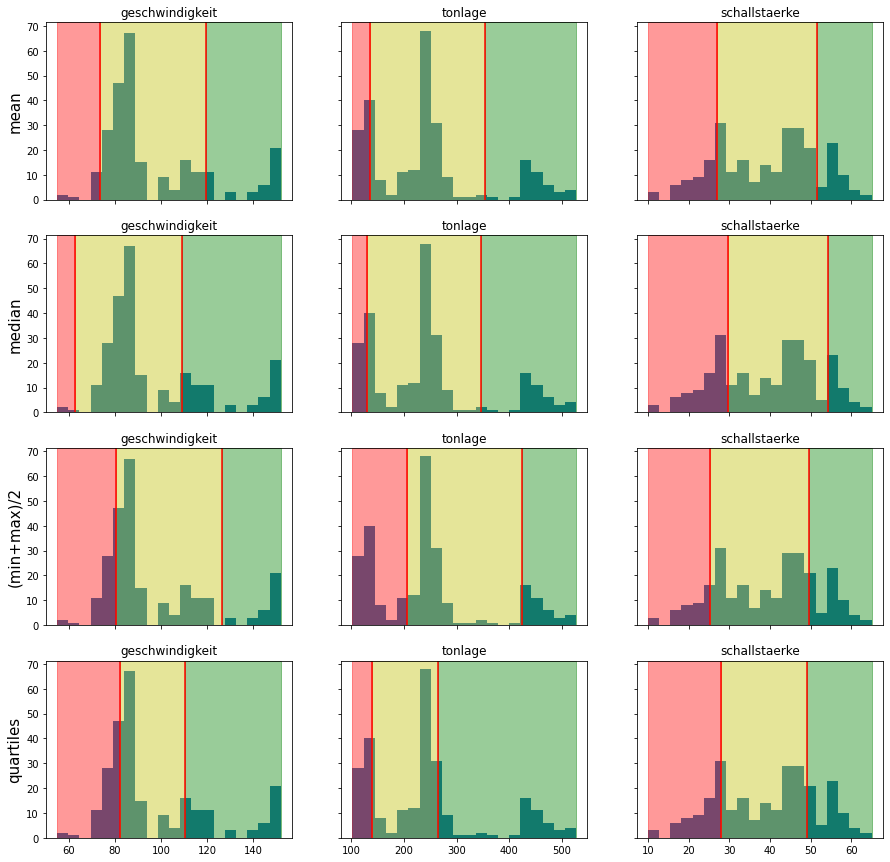

In [3]:
def mean_lower(col):
    return col.mean() - col.std() 

def mean_upper(col):
    return col.mean() + col.std() 

def median_lower(col):
    return col.median() - col.std()

def median_upper(col):
    return col.median() + col.std()

def half_min_max_lower(col):
    return (col.max() + col.min()) / 2 - col.std()

def half_min_max_upper(col):
    return (col.max() + col.min()) / 2 + col.std()

def quartile_lower(col):
    return col.quantile(0.25)

def quartile_upper(col):
    return col.quantile(0.75)


lower_funs = (mean_lower, median_lower, half_min_max_lower, quartile_lower) 
upper_funs = (mean_upper, median_upper, half_min_max_upper, quartile_upper)
fun_names = ("mean", "median", "(min+max)/2", "quartiles")
    
fig, axes = plt.subplots(nrows=len(lower_funs), ncols=3, figsize=(15,15),
                        sharex='col', sharey='row')

for lower_fun, upper_fun, name, row_axes in zip(lower_funs, upper_funs, fun_names, axes):
    
    for col_name, ax in zip(df, row_axes):
        col = df[col_name]

        col.plot.hist(bins=20, ax=ax)
        
        ax.axvline(lower_fun(col), color='r')
        ax.axvline(upper_fun(col), color='r')
        
        ax.axvspan(col.min(), lower_fun(col), alpha=0.4, color='r')
        ax.axvspan(lower_fun(col), upper_fun(col), alpha=0.4, color='y')
        ax.axvspan(upper_fun(col), col.max(), alpha=0.4, color='g')
        ax.set_title(col_name)
        
    row_axes[0].set_ylabel(name, size=15)

Using the mean or median and a 1-sigma interval will lead to barely any velocity being regarded as "low". Using quartiles seems like a robust measure which whill include some, but not too much of the heavy left tail in `tonlage`. It will also gives us a uniform distribution in the discrete data.

In [4]:
def _stringify(x, lower, upper):
    if x <= lower: return "low"
    if x >= upper: return "high"
    return "normal"

def discretize_using_fixed_borders(df):
    borders = {
        'geschwindigkeit': (80, 126),
        'tonlage': (180, 423),
        'schallstaerke': (25, 49)
    }

    for col in df:
        lower_border, upper_border = borders[col]

        df[col] = df[col].map(lambda x: _stringify(x, lower_border, upper_border))

    return df

def discretize_using_quartiles(df):
    for col in df:
        df[col] = pd.qcut(df[col],
                          q=(0, .25, .75, 1),
                          labels=('low', 'normal', 'high'))
    return df

def discretize_window(window):
    lower_quartiles = df.quantile(0.25)
    upper_quartiles = df.quantile(0.75)
    
    for col in window:
        window[col] = window[col].map(lambda entry: _stringify(entry,
                                                 lower_quartiles[col],
                                                 upper_quartiles[col]))
    return window


discrete_df = discretize_using_quartiles(df.copy())
discrete_df.head()

,geschwindigkeit,tonlage,schallstaerke
0,normal,normal,normal
1,normal,normal,normal
2,low,normal,normal
3,low,normal,normal
4,low,normal,normal


In [5]:
# Print the global quartiles to export them into the script
dict(df.quantile(0.25)), dict(df.quantile(0.75))

({'geschwindigkeit': 82.5, 'tonlage': 140.0, 'schallstaerke': 28.0},
 {'geschwindigkeit': 110.5, 'tonlage': 265.0, 'schallstaerke': 49.0})

Text(22.200000000000017, 0.5, 'quartiles')

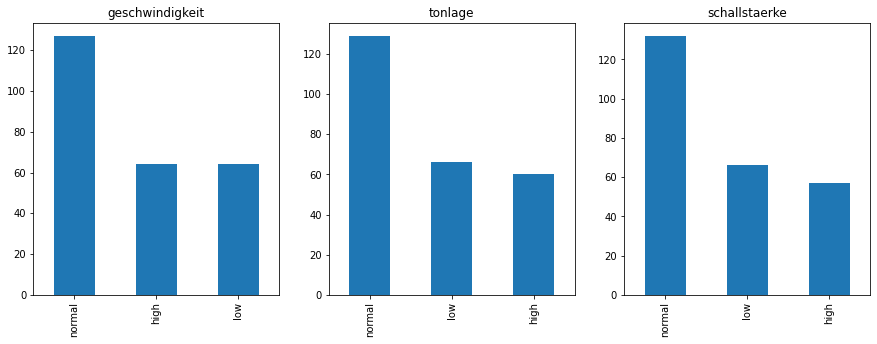

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for col_name, ax in zip(df, axes):
    col = discrete_df[col_name]

    col.value_counts().plot(kind='bar', ax=ax)

    ax.set_title(col_name)

row_axes[0].set_ylabel(name, size=15)

## Normalization

In the end we want to be able to say how much confidence we have in the statement _"the intensity was low in the last ten seconds"_. We need to be able to define a basic measure like this:

    m1(Traurigkeit) = 0.7

In order to map a windows concrete values to a percentage value, we calculate the discrete distribution in the last ten seconds:

For each feature we calculate how many of the last then steps were `low`, `normal` or `high`.

In [7]:
def discrete_distribution(discrete_window):
    dist = {}

    for col in discrete_window:
        window_counts = dict(discrete_window[col].value_counts())
        dist[col] = tuple(window_counts.get(level, 0) / len(discrete_window)
                          for level in ('low', 'normal', 'high'))

    return dist

### Example

As an example: The last ten seconds of the first sequence look like they have a comparitively high speed.

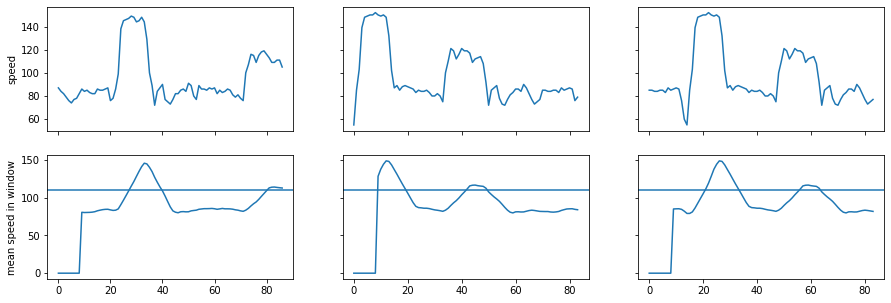

In [8]:
dfs = (df1, df2, df3)
vals = tuple(map(lambda df: df['geschwindigkeit'], dfs))
windows = tuple(map(lambda df: df.rolling(window=10)['geschwindigkeit'],
                   dfs))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5),
                         sharey='row', sharex='col')
val_axes, window_axes = axes
                         
for val, ax in zip(vals, val_axes):
    val.plot(ax=ax)
    ax.set_ylabel('speed')

for window, ax in zip(windows, window_axes):
    window.mean().fillna(0).plot(ax=ax)
    ax.axhline(df['geschwindigkeit'].quantile(0.75))
    ax.set_ylabel('mean speed in window')

In [9]:
last_window = df1[-10:]
window = last_window

discrete_window = discretize_window(window.copy())
discrete_distribution(discrete_window)

{'geschwindigkeit': (0.0, 0.3, 0.7),
 'tonlage': (0.0, 0.0, 1.0),
 'schallstaerke': (0.0, 0.8, 0.2)}

This gives us three basic measures:

    # high , low, normal
    mSpeed(A, Ü, W, F) = 0.7, mSpeed(F, E) = 0, mSpeed(Omega) = 0.3
    mPitch(A, Ü, W, F) = 1.0, mPitch(E, T) = 0, mPitch(Omega) = 0
    mIntensity(Ü, W, F) = 0.2, mIntensity(T) = 0, mIntensity(Omega) = 0.8

## Intensity: low deviations

We know about one more feature that has to be determined differently from the others: 

The fact that a high deviation in the intensity can indicate sadness.

How do we map the intensity in a window to a confidence $c \in \{0, 1\}$ that we can use in a basic measure? Using Min-Max-Scaling we can determine to confidence for the current window $w'$:

$$c_{w'} = \frac{\sigma_{w'} - \min_{w \subset W}\sigma_w }{\max_{w \subset W}\sigma_w - \min_{w \subset W}\sigma_w}$$

where $W$ is the set of all windows.

In [10]:
win_stds = df.rolling(window=10)['schallstaerke'].std()
global_min = win_stds.min()
global_max = win_stds.max()
global_min, global_max

(0.9660917830794542, 19.203298327804692)

In [11]:
def normalized_intensity_std(window):
    def _min_max_normalize(x, _min, _max):
        numerator = win_std - _min
        denominator = _max - _min
        return numerator / denominator

    win_std = window['schallstaerke'].std()

    global_max = 19.3
    global_min = 0.95

    return _min_max_normalize(win_std, global_min, global_max)

### Example

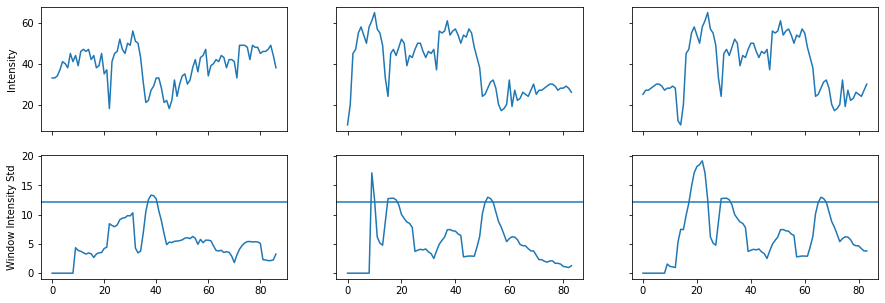

In [12]:
dfs = (df1, df2, df3)
vals = tuple(map(lambda df: df['schallstaerke'], dfs))
windows = tuple(map(lambda df: df.rolling(window=10)['schallstaerke'],
                   dfs))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5),
                         sharey='row', sharex='col')
val_axes, window_axes = axes
                         
val_axes[0].set_ylabel('Intensity')
for val, ax in zip(vals, val_axes):
    val.plot(ax=ax)

for window, ax in zip(windows, window_axes):
    window.std().fillna(0).plot(ax=ax)
    ax.axhline(df['schallstaerke'].std())
    ax.set_ylabel('Window Intensity Std')

At around 12 to 22 seconds in sequence 3:

In [13]:
window = df3[12:22]
window['schallstaerke'].std()

18.56789343643125

In [14]:
normalized_intensity_std(window)

0.960103184546662

Compared to the end of sequence 1:

In [15]:
window = df1[-10:]
normalized_intensity_std(window)

0.1262117887580874

Which gives us a forth basic measure:

    mIntensityStd(T) = 0.126, mIntensityStd(Omega) = (1 - 0.126)